In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import utils
from utils import ImagePair, ImageMatcher
import h5py
from scipy.spatial.transform import Rotation as Rot
import cv2
import matplotlib.pyplot as plt

In [3]:
DATA_DIR = '/Users/richard/Desktop/Dataset/'
#in_vid_path = DATA_DIR + 'real-t000.mp4'
in_vid_path = DATA_DIR + '3-3-v001-t000.mp4'
#in_vid_path = DATA_DIR + '../Kamera13_1620_1640.mp4'
frames = utils.load_video(in_vid_path,
                          grayscale=True)

#frames = [cv2.resize(frame, (640, 360)) for frame in frames]
print('n_frames:', len(frames))

n_frames: 900


In [4]:
matcher = ImageMatcher(frames)

Number of matches: 269


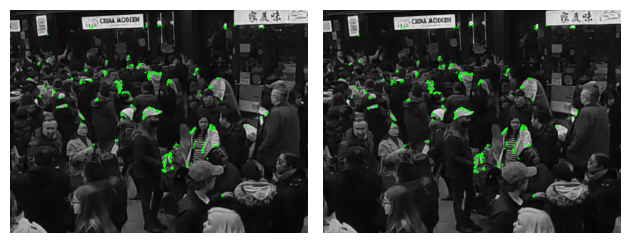

In [7]:
p = matcher.match(190, 191, min_match_count=250, verbose=True)
print(f'Number of matches: {len(p.src_pts)}')
utils.visualize_matches(p)

In [9]:
image_pairs = []
closures = []

interval = 30
for i in range(0, len(frames) - interval, interval):
    for j in range(i + interval, len(frames), interval):
        p = matcher.match(i, j, 'sift',
                          min_match_count=25)
        if p is None:
            continue
        closures.append(p)
        image_pairs.append(p)

for i in range(0, len(frames) - 1):
    p = matcher.match(i, i+1, min_match_count=200, verbose=True)
    if p is None:
        print('No match found for frames', i, i+1)
    image_pairs.append(p)

print('Number of loop closures:', len(closures))

Number of loop closures: 57


In [ ]:
for p in closures:
    print(f'Number of matches from {p.i} to {p.j}: {len(p.src_pts)}')
    utils.visualize_matches(p)

In [10]:
utils.export_image_pairs(DATA_DIR + f'cart10.h5', image_pairs)

In [11]:
cam_params_raw = utils.import_optimized_cam_params(DATA_DIR + 'optimized_cam_params.h5')

cam_params = {}
for i, p in cam_params_raw.items():
    cam_params[i] = {
        'R': Rot.from_rotvec(p[:3], degrees=False).as_matrix(),
        'hfov': 2 * np.degrees(np.arctan(320 / p[3])),
    }

In [12]:
trajs = np.load(DATA_DIR + 't000.npy')
cam_params_gt = {}
for i in cam_params.keys():
    p = trajs[i]
    cam_params_gt[i] = {
        'R': Rot.from_euler('YXZ', p[:3], degrees=True).as_matrix(),
        'hfov': p[3],
    }

base_R = cam_params[0]['R'].T.copy()
for p in cam_params.values():
    p['R'] = base_R @ p['R']

base_R = cam_params_gt[0]['R'].T.copy()
for p in cam_params_gt.values():
    p['R'] = base_R @ p['R']

In [13]:
# Compute the angular pose error and hfov error between cam_params and cam_params_gt
angular_errors = []
hfov_errors = []
for i in sorted(cam_params.keys()):
    R = cam_params[i]['R']
    R_gt = cam_params_gt[i]['R']
    angular_errors.append(np.degrees(Rot.from_matrix(R @ R_gt.T).magnitude()))
    hfov_errors.append(np.abs(cam_params[i]['hfov'] - cam_params_gt[i]['hfov']))

# pretty print the mean / max of angular and hfov errors to 5 sf
print(f'angular error mean: {np.mean(angular_errors):.5f}, max: {np.max(angular_errors):.5f}')
print(f'hfov error mean: {np.mean(hfov_errors):.5f}, max: {np.max(hfov_errors):.5f}')


angular error mean: 1.01480, max: 2.51906
hfov error mean: 0.65812, max: 2.25474


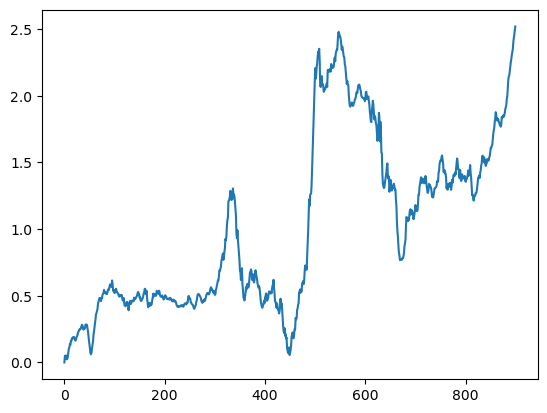

In [14]:
L, U = 0, 900
plt.plot(angular_errors[L:U])
plt.show()

In [ ]:
"""
Using: real-t000.mp4

    BA w/o loop closures:
        angular error mean: 0.66729, max: 1.12227
        hfov error mean: 0.28015, max: 0.67571

    BA w/ loop closures:
        angular error mean: 0.51575, max: 0.71856
        hfov error mean: 0.16311, max: 0.63163

Using: 3-3-v001-t000.mp4

    BA w/o loop closures (just pairwise matches):
        angular error mean: 2.56697, max: 6.22907
        hfov error mean: 1.22483, max: 5.85090

    BA w/ loop closures:
        angular error mean: 1.16865, max: 3.69337
        hfov error mean: 1.03221, max: 3.88494
""";

In [ ]:
# print gt hfovs
print('gt hfovs:')
for i in cam_params_gt.keys():
    print(f'{i}: {cam_params_gt[i]["hfov"]:.5f}')

# print optimized hfovs
print('optimized hfovs:')
for i in cam_params.keys():
    print(f'{i}: {cam_params[i]["hfov"]:.5f}')
